**<h1 align=left><font size = 12>Product Departement</font></h1>**
<p align=left><font size = 4>Owner: Rendy Kurniawan Emzet</p>
<p align=left><font size = 4>Case: Menganalisis pola dan penyebab product return oleh pelanggan berdasarkan data yang tersedia</p>
<hr></hr>

## **Data Loading, Exploration, Understanding, and Manipulation**

**1. libraries**

> Cell berikut berisi semua _library_ yang digunakan dan diurutkan mengikuti konvensi [PEP8](https://peps.python.org/pep-0008/).

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import graphviz
from pprint import pprint
from time import time
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

**2. Load dataset**

In [4]:
print('list file dalam directory:')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if filename[0] != '.' and '/.' not in dirname: #exclude hidden files
          print(dirname + '/' + filename)

list file dalam directory:
./distribution_centers.csv
./employees.csv
./events.csv
./inventory_items.csv
./orders.csv
./order_items.csv
./output_prediction.csv
./products.csv
./py.ipynb
./users.csv


In [14]:
start = time()
df_events = pd.read_csv("events.csv")
df_users = pd.read_csv("users.csv")
df_orders = pd.read_csv("orders.csv")
df_orderitems = pd.read_csv("order_items.csv")
df_inventory = pd.read_csv("inventory_items.csv")
df_products = pd.read_csv("products.csv")
df_warehouse = pd.read_csv("distribution_centers.csv")
end = time()

print("Done loading all datasets in {:.3f}s".format(end-start))

Done loading all datasets in 11.424s


**3. Datasets overview**

In [15]:
print("num of events:", df_events.shape[0], "\ncolums:" , df_events.columns.values.tolist(), "\n")
print("num of users:", df_users.shape[0], "\ncolums:" , df_users.columns.values.tolist(), "\n")
print("num of orders:", df_orders.shape[0], "\ncolums:" , df_orderitems.columns.values.tolist(), "\n")
print("num of order items:", df_orderitems.shape[0], "\ncolums:" , df_orderitems.columns.values.tolist(), "\n")
print("num of inventory:", df_inventory.shape[0], "\ncolums:" , df_inventory.columns.values.tolist(), "\n")
print("num of products:", df_products.shape[0], "\ncolums:" , df_products.columns.values.tolist(), "\n")
print("num of warehouse:", df_warehouse.shape[0], "\ncolums:" , df_warehouse.columns.values.tolist())

num of events: 2418734 
colums: ['id', 'user_id', 'sequence_number', 'session_id', 'created_at', 'ip_address', 'city', 'state', 'postal_code', 'browser', 'traffic_source', 'uri', 'event_type'] 

num of users: 100000 
colums: ['id', 'first_name', 'last_name', 'email', 'age', 'gender', 'state', 'street_address', 'postal_code', 'city', 'country', 'latitude', 'longitude', 'traffic_source', 'created_at'] 

num of orders: 124512 
colums: ['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id', 'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at', 'sale_price'] 

num of order items: 180508 
colums: ['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id', 'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at', 'sale_price'] 

num of inventory: 487394 
colums: ['id', 'product_id', 'created_at', 'sold_at', 'cost', 'product_category', 'product_name', 'product_brand', 'product_retail_price', 'product_department', 'product_sku', 'product_distribution_cent

> Masing-masing dataset memiliki primary key serta foreign key sehingga dapat saling dihubungkan/dilakukan join.
> Beberapa kolom di setiap dataset memiiki nilai yang sama persis, dengan hal ini, dataset 'Order' dan 'Product' dipakai karena bersifat redundant
> | ![Relasi Dataset](/relasi_dataset.jpg) | 
> |:--:| 

**4. Data exploration and manipulation**

In [22]:
df_orderitems.head()

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,59347,41038,33153,13606,160256,Shipped,2020-01-05 08:14:27+00:00,2020-01-06 20:56:00+00:00,NaT,NaT,2.5
1,101072,69979,56200,13606,272958,Shipped,2022-05-17 07:06:19+00:00,2022-05-19 10:42:00+00:00,NaT,NaT,2.5
2,63687,44006,35515,13606,171991,Complete,2021-01-21 04:56:58+00:00,2021-01-19 07:16:00+00:00,2021-01-22 03:38:00+00:00,NaT,2.5
3,16338,11275,9230,13606,44149,Cancelled,2022-05-31 08:55:48.353609+00:00,NaT,NaT,NaT,2.5
4,85756,59418,47846,13606,231665,Cancelled,2022-05-22 11:36:45+00:00,NaT,NaT,NaT,2.5


In [19]:
print("Total order = {}, total kasus return = {}".format(
    df_orderitems.shape[0],df_orderitems[df_orderitems["status"]=="Returned"].shape[0]))

Total order = 180508, total kasus return = 17752


In [20]:
df_orderitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 180508 non-null  int64  
 1   order_id           180508 non-null  int64  
 2   user_id            180508 non-null  int64  
 3   product_id         180508 non-null  int64  
 4   inventory_item_id  180508 non-null  int64  
 5   status             180508 non-null  object 
 6   created_at         180508 non-null  object 
 7   shipped_at         117502 non-null  object 
 8   delivered_at       63035 non-null   object 
 9   returned_at        17752 non-null   object 
 10  sale_price         180508 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 15.1+ MB


> Kolom created_at, shipped_at, delivered at, dan returned_at masih dalam format object

In [21]:
df_orderitems['created_at'] =  pd.to_datetime(df_orderitems.created_at)
df_orderitems['shipped_at'] =  pd.to_datetime(df_orderitems.shipped_at)
df_orderitems['returned_at'] =  pd.to_datetime(df_orderitems.returned_at)
df_orderitems['delivered_at'] =  pd.to_datetime(df_orderitems.delivered_at)
df_orderitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 180508 non-null  int64              
 1   order_id           180508 non-null  int64              
 2   user_id            180508 non-null  int64              
 3   product_id         180508 non-null  int64              
 4   inventory_item_id  180508 non-null  int64              
 5   status             180508 non-null  object             
 6   created_at         180508 non-null  datetime64[ns, UTC]
 7   shipped_at         117502 non-null  datetime64[ns, UTC]
 8   delivered_at       63035 non-null   datetime64[ns, UTC]
 9   returned_at        17752 non-null   datetime64[ns, UTC]
 10  sale_price         180508 non-null  float64            
dtypes: datetime64[ns, UTC](4), float64(1), int64(5), object(1)
memory usage: 15.1+ MB


> membuat column jarak waktu antara created_at - shipped_at dan shipped_at - delivered_at

In [23]:
if df_orderitems['shipped_at'].notna and df_orderitems['created_at'].notna:
    df_orderitems['days_createdShipped'] = (df_orderitems['shipped_at'].dt.day - df_orderitems['created_at'].dt.day).abs()
if df_orderitems['delivered_at'].notna and df_orderitems['shipped_at'].notna:
    df_orderitems['days_shippedDelivered'] = (df_orderitems['delivered_at'].dt.day - df_orderitems['shipped_at'].dt.day).abs()
df_orderitems

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,days_createdShipped,days_shippedDelivered
0,59347,41038,33153,13606,160256,Shipped,2020-01-05 08:14:27+00:00,2020-01-06 20:56:00+00:00,NaT,NaT,2.50,1.0,NaN
1,101072,69979,56200,13606,272958,Shipped,2022-05-17 07:06:19+00:00,2022-05-19 10:42:00+00:00,NaT,NaT,2.50,2.0,NaN
2,63687,44006,35515,13606,171991,Complete,2021-01-21 04:56:58+00:00,2021-01-19 07:16:00+00:00,2021-01-22 03:38:00+00:00,NaT,2.50,2.0,3.0
3,16338,11275,9230,13606,44149,Cancelled,2022-05-31 08:55:48.353609+00:00,NaT,NaT,NaT,2.50,NaN,NaN
4,85756,59418,47846,13606,231665,Cancelled,2022-05-22 11:36:45+00:00,NaT,NaT,NaT,2.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,102243,70792,56851,3633,276090,Processing,2022-01-14 04:07:53+00:00,NaT,NaT,NaT,9.32,NaN,NaN
180504,134300,92879,74538,3633,362611,Processing,2021-12-13 05:53:52+00:00,NaT,NaT,NaT,9.32,NaN,NaN
180505,169592,117130,94127,3449,457985,Shipped,2020-12-08 04:56:12+00:00,2020-12-04 17:42:00+00:00,NaT,NaT,9.82,4.0,NaN
180506,84906,58830,47366,3449,229398,Complete,2019-03-04 12:43:19+00:00,2019-03-01 15:24:00+00:00,2019-03-03 05:05:00+00:00,NaT,9.82,3.0,2.0


In [24]:
df_orderitems[['days_createdShipped','days_shippedDelivered']].describe() 

,days_createdShipped,days_shippedDelivered
count,117502.000000,63035.000000
mean,3.025668,4.639883
std,6.453225,7.234970
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,3.000000
75%,2.000000,4.000000
max,30.000000,30.000000


Dikarenakan banyak terdapat data null, maka kolom ini tidak bisa dijadikan variabel <br>
Namun, kolom-kolom ini dapat untuk dijadikan analisis untuk data orderan yang **returned**

> Join dataset OrderItems dengan dataset Inventory dan Warehouse

In [26]:
df_orderitems_drop = df_orderitems[["id","user_id","inventory_item_id","status","sale_price"]] #define variabel dengan column terpilih
df_orderitemsInventory = pd.merge(df_orderitems_drop, df_inventory.add_prefix('inventory_'), left_on='inventory_item_id', right_on='inventory_id', how='left')
df_orderitemsInventoryWarehouse = pd.merge(df_orderitemsInventory, df_warehouse.add_prefix('warehouse_'), left_on='inventory_product_distribution_center_id', right_on='warehouse_id', how='left')
df_orderitemsInventoryWarehouse = df_orderitemsInventoryWarehouse.drop(columns=['inventory_item_id','inventory_product_id','inventory_product_retail_price', 'inventory_created_at','warehouse_id','inventory_id','inventory_sold_at','inventory_product_sku','inventory_product_distribution_center_id']) #drop column yang tidak diperlukan
df_orderitemsInventoryWarehouse.head()


,id,user_id,status,sale_price,inventory_cost,inventory_product_category,inventory_product_name,inventory_product_brand,inventory_product_department,warehouse_name,warehouse_latitude,warehouse_longitude
0,59347,33153,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,-95.3698
1,101072,56200,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,-95.3698
2,63687,35515,Complete,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,-95.3698
3,16338,9230,Cancelled,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,-95.3698
4,85756,47846,Cancelled,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,-95.3698


In [27]:
df_orderitemsInventoryWarehouse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180508 entries, 0 to 180507
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            180508 non-null  int64  
 1   user_id                       180508 non-null  int64  
 2   status                        180508 non-null  object 
 3   sale_price                    180508 non-null  float64
 4   inventory_cost                180508 non-null  float64
 5   inventory_product_category    180508 non-null  object 
 6   inventory_product_name        180496 non-null  object 
 7   inventory_product_brand       180365 non-null  object 
 8   inventory_product_department  180508 non-null  object 
 9   warehouse_name                180508 non-null  object 
 10  warehouse_latitude            180508 non-null  float64
 11  warehouse_longitude           180508 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory us

> isi null pada ***product_name*** dan ***product_brand*** dengan **Unnamed**

In [28]:
df_orderitemsInventoryWarehouse = df_orderitemsInventoryWarehouse.fillna('Unnamed')
df_orderitemsInventoryWarehouse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180508 entries, 0 to 180507
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            180508 non-null  int64  
 1   user_id                       180508 non-null  int64  
 2   status                        180508 non-null  object 
 3   sale_price                    180508 non-null  float64
 4   inventory_cost                180508 non-null  float64
 5   inventory_product_category    180508 non-null  object 
 6   inventory_product_name        180508 non-null  object 
 7   inventory_product_brand       180508 non-null  object 
 8   inventory_product_department  180508 non-null  object 
 9   warehouse_name                180508 non-null  object 
 10  warehouse_latitude            180508 non-null  float64
 11  warehouse_longitude           180508 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory us

> join tabel hasil olahan dengan dataset *users*

In [29]:
df_orderitemsInventoryWarehouseUsers = pd.merge(df_orderitemsInventoryWarehouse, df_users.add_prefix('user_'), on='user_id', how='left')
df_orderitemsInventoryWarehouseUsers['user_created_at'] =  pd.to_datetime(df_orderitemsInventoryWarehouseUsers.user_created_at) #ubah type kolom ke datetime
df_orderitemsInventoryWarehouseUsers = df_orderitemsInventoryWarehouseUsers.drop(columns=['user_first_name','user_last_name','user_email']) #drop column yang tidak diperlukan dan redundant
df_orderitemsInventoryWarehouseUsers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180508 entries, 0 to 180507
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   id                            180508 non-null  int64              
 1   user_id                       180508 non-null  int64              
 2   status                        180508 non-null  object             
 3   sale_price                    180508 non-null  float64            
 4   inventory_cost                180508 non-null  float64            
 5   inventory_product_category    180508 non-null  object             
 6   inventory_product_name        180508 non-null  object             
 7   inventory_product_brand       180508 non-null  object             
 8   inventory_product_department  180508 non-null  object             
 9   warehouse_name                180508 non-null  object             
 10  warehouse_latitude  

> Terdapat null pada *user_city*, isi null dengan 'Unknown'

In [30]:
df_orderitemsInventoryWarehouseUsers = df_orderitemsInventoryWarehouseUsers.fillna('Unknown')
df_orderitemsInventoryWarehouseUsers[['status','user_city']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180508 entries, 0 to 180507
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   status     180508 non-null  object
 1   user_city  180508 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


> Join data hasil olahan dengan dataset *events*

In [31]:
df_orderitemsInventoryWarehouseUsersEvents = pd.merge(df_orderitemsInventoryWarehouseUsers, df_events.add_prefix('event_'), left_on='user_id', right_on='event_user_id', how='left')
df_orderitemsInventoryWarehouseUsersEvents['event_created_at'] = pd.to_datetime(df_orderitemsInventoryWarehouseUsersEvents.event_created_at) #ubah ke type datetime
df_orderitemsInventoryWarehouseUsersEvents = df_orderitemsInventoryWarehouseUsersEvents.drop(columns=['event_user_id','user_id','event_ip_address','event_city','event_state','event_postal_code','event_traffic_source']) #drop data redundant

In [32]:
df_orderitemsInventoryWarehouseUsersEvents.head(5)

,id,status,sale_price,inventory_cost,inventory_product_category,inventory_product_name,inventory_product_brand,inventory_product_department,warehouse_name,warehouse_latitude,...,user_longitude,user_traffic_source,user_created_at,event_id,event_sequence_number,event_session_id,event_created_at,event_browser,event_uri,event_event_type
0,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,123.485452,Facebook,2019-10-18 08:18:00+00:00,424498,1,66469ed2-904c-4c08-b1c7-060bb591e783,2020-01-05 08:06:47+00:00,Chrome,/home,home
1,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,123.485452,Facebook,2019-10-18 08:18:00+00:00,424503,1,ec4d2640-e1ab-4fda-916e-e8a6d9e7a811,2021-02-13 08:07:23+00:00,Chrome,/home,home
2,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,123.485452,Facebook,2019-10-18 08:18:00+00:00,424504,2,ec4d2640-e1ab-4fda-916e-e8a6d9e7a811,2021-02-13 08:09:58+00:00,Chrome,/department/women/category/tops&tees/brand/all...,department
3,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,123.485452,Facebook,2019-10-18 08:18:00+00:00,424499,2,66469ed2-904c-4c08-b1c7-060bb591e783,2020-01-05 08:09:40+00:00,Chrome,/department/women/category/accessories/brand/s...,department
4,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,123.485452,Facebook,2019-10-18 08:18:00+00:00,424505,3,ec4d2640-e1ab-4fda-916e-e8a6d9e7a811,2021-02-13 08:10:14+00:00,Chrome,/product/375,product


In [33]:
df_orderitemsInventoryWarehouseUsersEvents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4912307 entries, 0 to 4912306
Data columns (total 29 columns):
 #   Column                        Dtype              
---  ------                        -----              
 0   id                            int64              
 1   status                        object             
 2   sale_price                    float64            
 3   inventory_cost                float64            
 4   inventory_product_category    object             
 5   inventory_product_name        object             
 6   inventory_product_brand       object             
 7   inventory_product_department  object             
 8   warehouse_name                object             
 9   warehouse_latitude            float64            
 10  warehouse_longitude           float64            
 11  user_age                      int64              
 12  user_gender                   object             
 13  user_state                    object             
 14  us

> hubungan dataset hasil olahan sebelumnya dengan dataset events bersifat ***one to many***, dimana sebelumnya **dari 180508 entries menjadi 4912307 entries**


>mengambil browser, total sequence, dan jumlah sesi pada dataset events dengan fungsi *groupby* pada 'id'

In [34]:
event_seq = df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_sequence_number.max().reset_index(name="event_max_sequence")
event_ses = df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_session_id.nunique().reset_index(name="event_total_session")
event_browser = df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_browser.max().reset_index(name="event_browser")

df_all_p1 = pd.merge(df_orderitemsInventoryWarehouseUsers, event_ses, on='id', how='left')
df_all_p2 = pd.merge(df_all_p1, event_seq, on='id', how='left')
df_all = pd.merge(df_all_p2, event_browser, on='id', how='left')
df_all = df_all.drop(columns=['user_created_at','user_id','user_postal_code'])

In [35]:
df_all.head()

,id,status,sale_price,inventory_cost,inventory_product_category,inventory_product_name,inventory_product_brand,inventory_product_department,warehouse_name,warehouse_latitude,...,user_state,user_street_address,user_city,user_country,user_latitude,user_longitude,user_traffic_source,event_total_session,event_max_sequence,event_browser
0,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Liaoning,8796 Dominguez Overpass,Fuzhou,China,41.719322,123.485452,Facebook,2,5,Chrome
1,101072,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,England,8646 Austin Radial Apt. 151,London,United Kingdom,51.460341,-0.137739,Search,1,5,Chrome
2,63687,Complete,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Bretagne,862 Christopher Radial Suite 221,Vannes,France,47.659633,-2.757229,Search,6,10,Safari
3,16338,Cancelled,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Liaoning,3016 Kelly Spurs,Hefei,China,41.232055,123.219074,Email,1,5,Other
4,85756,Cancelled,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Cataluña,16392 Robinson Harbors Apt. 238,Mataró,Spain,41.540629,2.448863,Organic,7,7,Safari


In [36]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180508 entries, 0 to 180507
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            180508 non-null  int64  
 1   status                        180508 non-null  object 
 2   sale_price                    180508 non-null  float64
 3   inventory_cost                180508 non-null  float64
 4   inventory_product_category    180508 non-null  object 
 5   inventory_product_name        180508 non-null  object 
 6   inventory_product_brand       180508 non-null  object 
 7   inventory_product_department  180508 non-null  object 
 8   warehouse_name                180508 non-null  object 
 9   warehouse_latitude            180508 non-null  float64
 10  warehouse_longitude           180508 non-null  float64
 11  user_age                      180508 non-null  int64  
 12  user_gender                   180508 non-nul

> Dataset hasil manipulasi telah **clean** dengan nama 'df__all'

> Korelasi antar kolom

<AxesSubplot:>

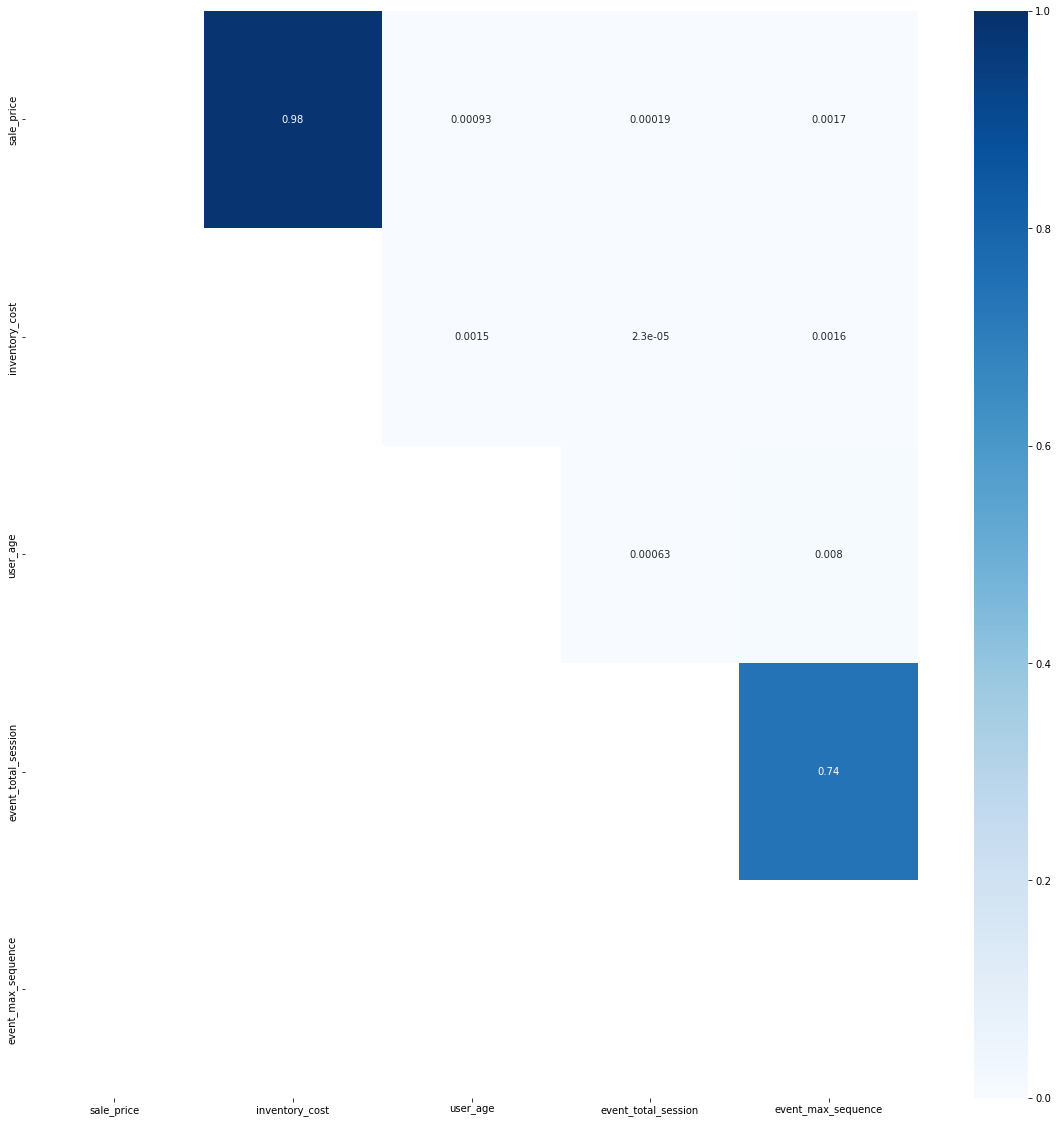

In [37]:
df_all_corr = df_all.drop(columns=['id','warehouse_latitude','warehouse_longitude','user_latitude','user_longitude']).corr().abs()
upper = df_all_corr.where(np.triu(np.ones(df_all_corr.shape), k=1).astype(np.bool_))
plt.figure(figsize=(20,20))
sns.heatmap(upper, data=df_all_corr, annot=True, cmap="Blues", vmin=0, vmax=1)

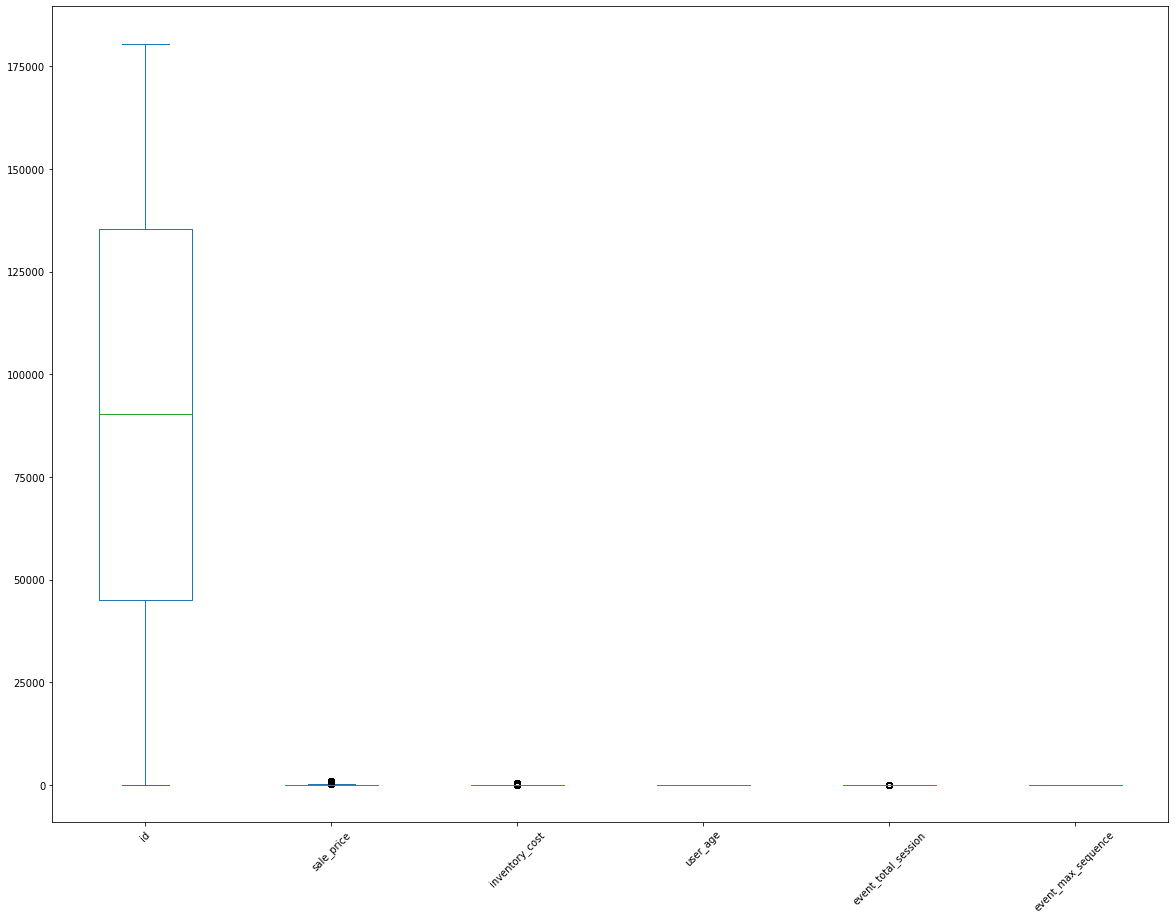

In [38]:
df_all.drop(columns=['warehouse_latitude','warehouse_longitude','user_latitude','user_longitude']).plot(kind="box", figsize=(20, 15))
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

> outliers yang teridentifikasi merupakan natural (bukan kesalahan input), sehingga outliers tersebut tidak dihilangkan

**5. Data understanding terhadap  product return**

In [39]:
df_orderitems[df_orderitems["status"]=="Returned"]['returned_at'].groupby([df_orderitems[df_orderitems["status"]=="Returned"]['returned_at'].dt.year.rename('year'), df_orderitems[df_orderitems["status"]=="Returned"]['returned_at'].dt.month.rename('month')]).agg({'count'})

count
year month       
2019 1          4
     2          7
     3         27
     4         36
     5         38
     6         53
     7         97
     8         89
     9         98
     10       117
     11       116
     12       130
2020 1        151
     2        191
     3        158
     4        184
     5        213
     6        255
     7        242
     8        264
     9        295
     10       313
     11       349
     12       355
2021 1        407
     2        335
     3        447
     4        513
     5        516
     6        487
     7        542
     8        659
     9        603
     10       793
     11       724
     12       859
2022 1        951
     2        928
     3       1177
     4       1229
     5       1851
     6        949

<AxesSubplot:xlabel='year', ylabel='count'>

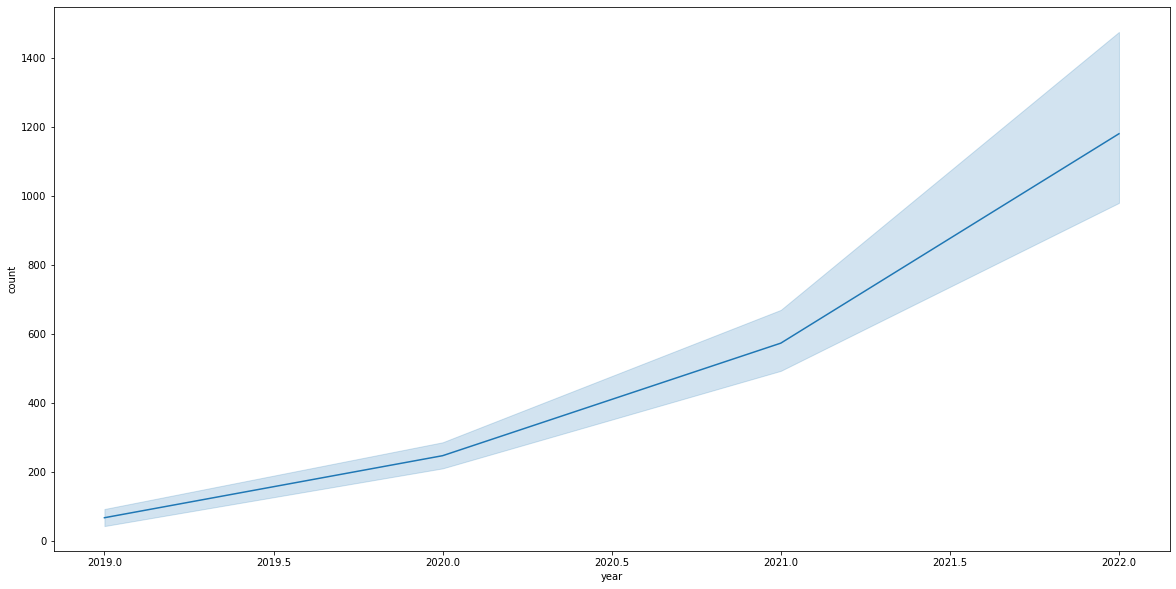

In [40]:
groupby_count = df_orderitems[df_orderitems["status"]=="Returned"]['returned_at'].groupby([df_orderitems[df_orderitems["status"]=="Returned"]['returned_at'].dt.year.rename('year'), df_orderitems[df_orderitems["status"]=="Returned"]['returned_at'].dt.month.rename('month')]).agg({'count'})
plt.figure(figsize=(20,10))
sns.lineplot(x='year', y='count', data=groupby_count)

<AxesSubplot:xlabel='monthly', ylabel='count'>

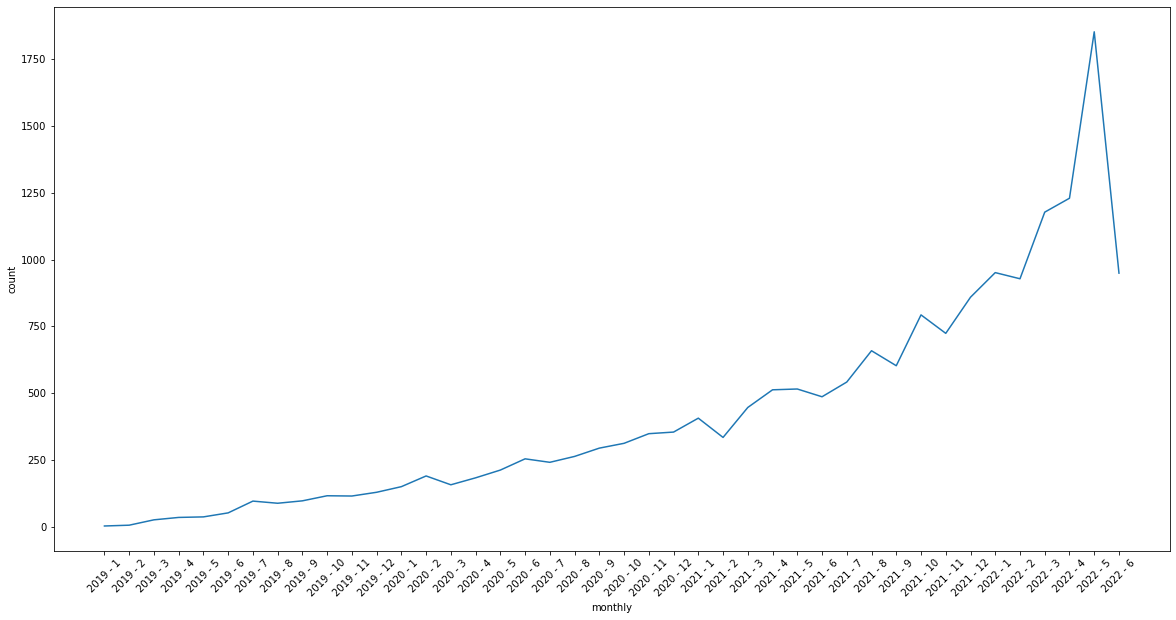

In [41]:
df_groupby_count = groupby_count.reset_index(['year','month'])
df_groupby_count['monthly'] = df_groupby_count.year.astype(str) + ' - ' + df_groupby_count.month.astype(str)
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.lineplot(x='monthly', y='count', data=df_groupby_count)

> pada grafik, 2022-6 terlihat seperti terjadi penurunan angka retur barang. Hal ini salah karena pada bulan tersebut, tanggal yang terakhir masuk bukan merupakan akhir bulan=

<AxesSubplot:xlabel='monthly', ylabel='count'>

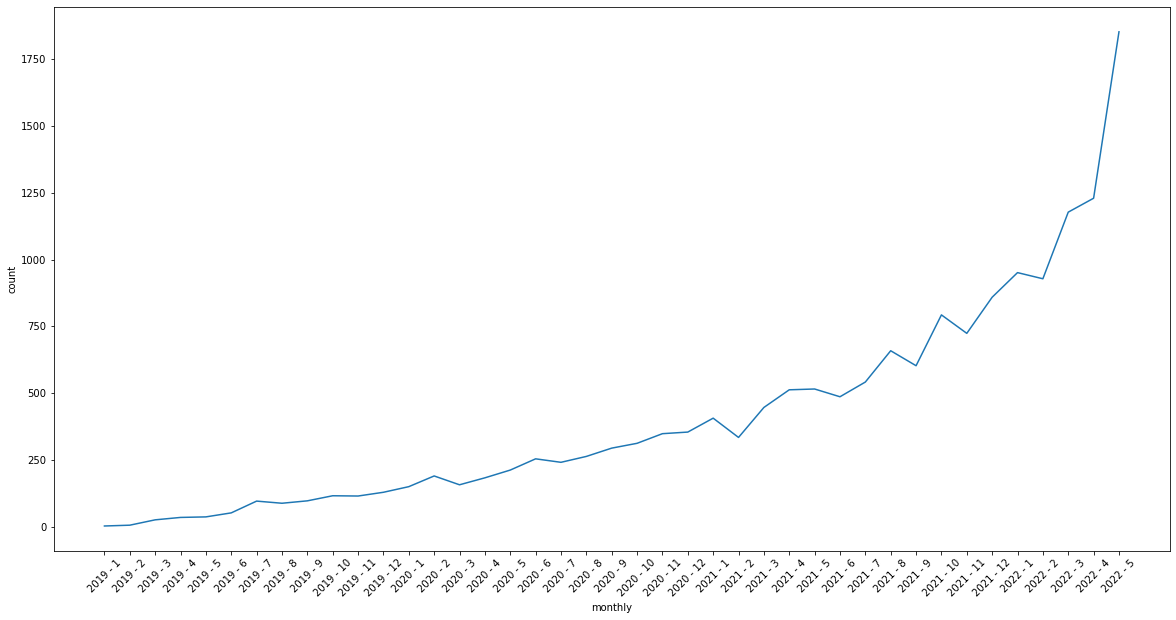

In [42]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.lineplot(x='monthly', y='count', data=df_groupby_count.drop(df_groupby_count[df_groupby_count['monthly']=='2022 - 6'].index))

> **Forecasting dapat dilakukan pada data ini**

| -- |

summary statistics

In [43]:
display(df_orderitems[["status","created_at","shipped_at","delivered_at","sale_price"]][df_orderitems["status"]=="Returned"])
display(df_orderitems[["status","created_at","shipped_at","delivered_at","sale_price"]][df_orderitems["status"]=="Returned"].describe())

,status,created_at,shipped_at,delivered_at,sale_price
11,Returned,2021-11-02 02:32:52+00:00,2021-11-02 12:34:00+00:00,2021-11-06 20:31:00+00:00,3.00
12,Returned,2021-10-12 07:11:30+00:00,2021-10-13 00:10:00+00:00,2021-10-14 01:20:00+00:00,3.00
19,Returned,2021-09-29 13:50:43+00:00,2021-10-01 05:37:00+00:00,2021-10-03 01:21:00+00:00,3.25
42,Returned,2021-01-24 05:16:23+00:00,2021-01-26 22:32:00+00:00,2021-01-27 23:05:00+00:00,3.50
43,Returned,2022-05-11 12:05:34+00:00,2022-05-13 04:20:00+00:00,2022-05-14 20:09:00+00:00,3.50
...,...,...,...,...,...
180485,Returned,2022-05-30 10:53:17+00:00,2022-05-29 17:43:00+00:00,2022-06-02 02:07:00+00:00,8.82
180486,Returned,2021-07-30 00:58:57+00:00,2021-07-30 22:23:00+00:00,2021-08-01 01:52:00+00:00,8.82
180487,Returned,2022-03-23 14:45:29+00:00,2022-03-23 12:17:00+00:00,2022-03-27 19:50:00+00:00,8.82
180488,Returned,2020-12-29 10:55:02+00:00,2020-12-31 00:28:00+00:00,2021-01-02 15:30:00+00:00,8.82


,sale_price
count,17752.000000
mean,60.003264
std,67.816669
min,0.490000
25%,24.000000
50%,39.990002
75%,69.980003
max,999.000000


In [44]:
#define fungsi plot_count
def plot_count(data, x=None, y=None, palette=None, figsize=(12, 6), **kwargs):
    column_order = data[x or y].value_counts().index

    plt.figure(figsize=figsize)
    # plt.tick_params(axis='x', rotation=90)
    sns.countplot(
        x=x, y=y, data=data, order=column_order,
        palette=palette, **kwargs
    )
    plt.grid(False)
MAIN_COLOR = ["#29B5BF"]    # warna utama untuk visualisasi
OTHER_COLOR = ["#777777"]    # warna lainnya untuk visualisasi

None

,inventory_product_department,count
0,Men,8767
1,Women,8985


None

,inventory_product_category,count
7,Jeans,1283
6,Intimates,1278
24,Tops & Tees,1215
5,Fashion Hoodies & Sweatshirts,1147
15,Shorts,1080
17,Sleep & Lounge,1071
23,Swim,1065
22,Sweaters,1046
0,Accessories,972
11,Outerwear & Coats,854


None

,warehouse_name,count
4,Memphis TN,2393
1,Chicago IL,2273
2,Houston TX,2229
5,Mobile AL,1824
3,Los Angeles CA,1731
8,Port Authority of New York/New Jersey NY/NJ,1629
0,Charleston SC,1626
7,Philadelphia PA,1578
6,New Orleans LA,1284
9,Savannah GA,1185


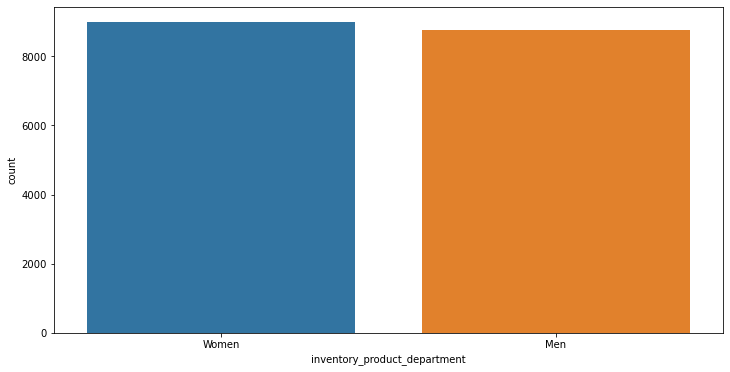

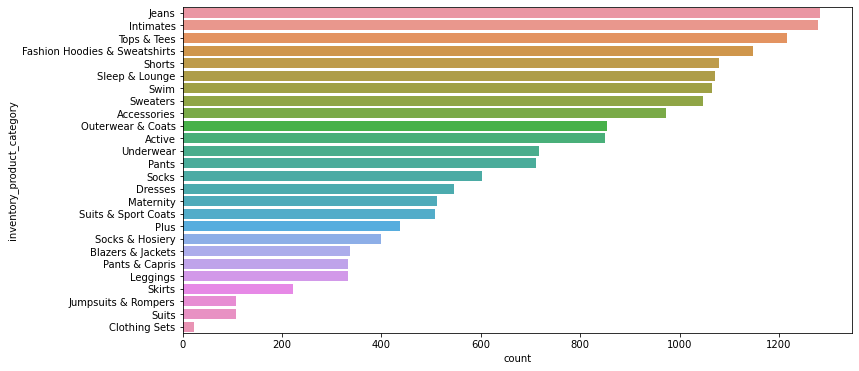

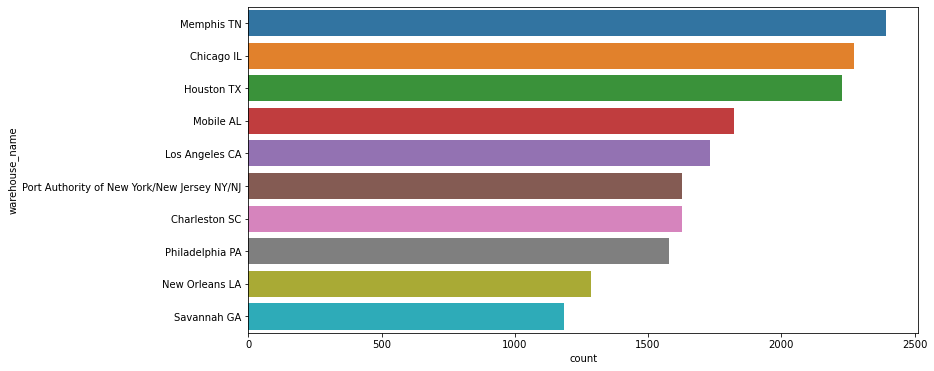

In [45]:
display(plot_count(x="inventory_product_department", data=df_orderitemsInventoryWarehouse[df_orderitemsInventoryWarehouse["status"]=="Returned"]))
display(df_orderitemsInventoryWarehouse[df_orderitemsInventoryWarehouse["status"]=="Returned"].groupby('inventory_product_department').id.count().reset_index(name='count'))
display(plot_count(y="inventory_product_category", data=df_orderitemsInventoryWarehouse[df_orderitemsInventoryWarehouse["status"]=="Returned"]))
display(df_orderitemsInventoryWarehouse[df_orderitemsInventoryWarehouse["status"]=="Returned"].groupby('inventory_product_category').id.count().reset_index(name='count').sort_values(by='count', ascending=False))
display(plot_count(y='warehouse_name', data=df_orderitemsInventoryWarehouse[df_orderitemsInventoryWarehouse["status"]=="Returned"]))
display(df_orderitemsInventoryWarehouse[df_orderitemsInventoryWarehouse["status"]=="Returned"].groupby('warehouse_name').id.count().reset_index(name='count').sort_values(by='count', ascending=False))


> Informasi umur pembeli yang melakukan product return

In [46]:
df_orderitemsInventoryWarehouseUsers['user_age'][df_orderitemsInventoryWarehouseUsers['status']=='Returned'].describe()

count    17752.000000
mean        41.099932
std         16.983502
min         12.000000
25%         26.000000
50%         41.000000
75%         56.000000
max         70.000000
Name: user_age, dtype: float64

,user_country,count
3,China,6002
13,United States,4025
2,Brasil,2621
10,South Korea,935
7,Germany,811
12,United Kingdom,796
6,France,780
11,Spain,747
0,Australia,412
8,Japan,380


None

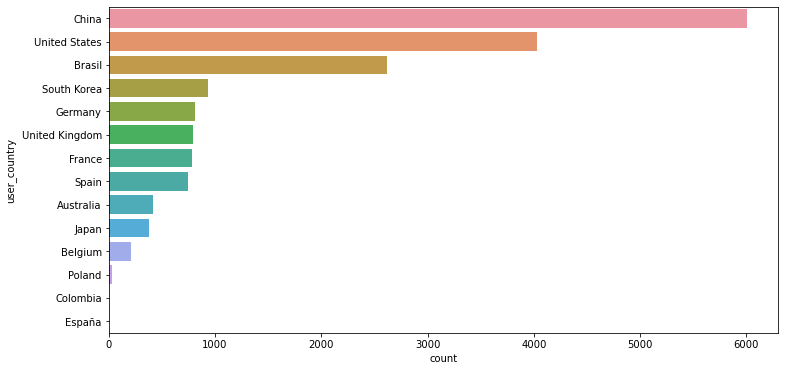

In [47]:
display(df_orderitemsInventoryWarehouseUsers[df_orderitemsInventoryWarehouseUsers["status"]=="Returned"].groupby('user_country')['user_country'].count().reset_index(name="count").sort_values(by='count', ascending=False))
display(plot_count(y='user_country', data=df_orderitemsInventoryWarehouseUsers[df_orderitemsInventoryWarehouseUsers["status"]=="Returned"]))

Diketahui ada 13 negara yang penduduknya pernah melakukan product return, pelanggan dari CHina melakukan proses product return terbanyak, yaitu sebanyak 6002 kali 

In [48]:
df_orderitemsInventoryWarehouseUsers[df_orderitemsInventoryWarehouseUsers["status"]=="Returned"].groupby('user_state')['user_state'].count().reset_index(name="count").sort_values(by='count', ascending=False)

,user_state,count
63,Guangdong,963
50,England,700
27,California,689
191,Texas,446
181,Shanghai,401
...,...,...
43,Corse,1
83,Ibaraki,1
9,Aomori,1
210,Zachodniopomorskie,1


Terdapat total lokasi pengguna yang melakukan return sebanyak 213 lokasi, dengan Guangdong memiliki jumlah kasus product return terbanyak

,user_traffic_source,count
4,Search,12494
3,Organic,2591
2,Facebook,1097
1,Email,832
0,Display,738


None

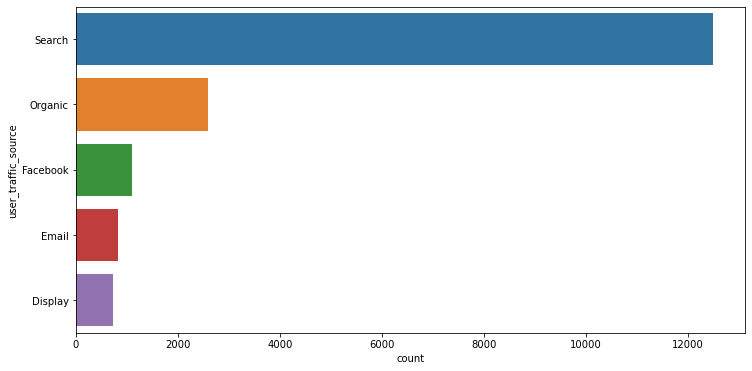

In [49]:
display(df_orderitemsInventoryWarehouseUsers[df_orderitemsInventoryWarehouseUsers["status"]=="Returned"].groupby('user_traffic_source')['user_traffic_source'].count().reset_index(name="count").sort_values(by='count', ascending=False))
display(plot_count(y='user_traffic_source', data=df_orderitemsInventoryWarehouseUsers[df_orderitemsInventoryWarehouseUsers["status"]=="Returned"]))

Pelanggan yang melakukan product return didominasi dari yang mendapatkan informasi produk melalui **Search**

,browser,count
0,Chrome,33857
1,Firefox,32900
2,IE,12055
3,Other,14178
4,Safari,87518


None

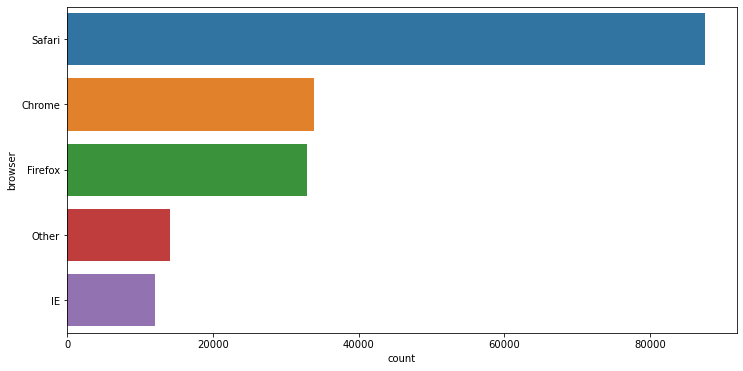

In [50]:
display(df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_browser.max().reset_index(name="browser").groupby('browser').browser.count().reset_index(name="count"))
display(plot_count(y='browser', data=df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_browser.max().reset_index(name="browser")))

Pengguna yang melakukan product return mayoritas memakai browser *Safari* 

In [51]:
df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_sequence_number.max().reset_index(name="event_max_sequence")

,id,event_max_sequence
0,1,13
1,2,13
2,3,13
3,4,13
4,5,13
...,...,...
180503,180504,7
180504,180505,5
180505,180506,5
180506,180507,5


In [52]:
df_orderitemsInventoryWarehouseUsersEvents.groupby('id').event_session_id.nunique().reset_index(name="event_total_session")

,id,event_total_session
0,1,8
1,2,8
2,3,8
3,4,8
4,5,8
...,...,...
180503,180504,3
180504,180505,1
180505,180506,1
180506,180507,2


> **dari dataset hasil olahan tersebut, bisa dilakukan model klasifikasi untuk menentukan barang berstatus retur**. Analisis dapat dilakukan setelahnya dengan melihat hasil decision tree yang didapatkan sehingga dapat diidentifikasi variabel mana yang menjadi prioritas untuk mencari penyebab terjadinya barang retur

| -- |

## **Modelling**

**1. Data preparation**

In [53]:
df_all.head()

,id,status,sale_price,inventory_cost,inventory_product_category,inventory_product_name,inventory_product_brand,inventory_product_department,warehouse_name,warehouse_latitude,...,user_state,user_street_address,user_city,user_country,user_latitude,user_longitude,user_traffic_source,event_total_session,event_max_sequence,event_browser
0,59347,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Liaoning,8796 Dominguez Overpass,Fuzhou,China,41.719322,123.485452,Facebook,2,5,Chrome
1,101072,Shipped,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,England,8646 Austin Radial Apt. 151,London,United Kingdom,51.460341,-0.137739,Search,1,5,Chrome
2,63687,Complete,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Bretagne,862 Christopher Radial Suite 221,Vannes,France,47.659633,-2.757229,Search,6,10,Safari
3,16338,Cancelled,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Liaoning,3016 Kelly Spurs,Hefei,China,41.232055,123.219074,Email,1,5,Other
4,85756,Cancelled,2.5,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,Cataluña,16392 Robinson Harbors Apt. 238,Mataró,Spain,41.540629,2.448863,Organic,7,7,Safari


membuat kolom status dengan 0 = non returned, 1= returned

In [54]:
df = df_all.copy() #df_all adalah data hasil manipulation beberapa dataset olahan sebelumnya
df.loc[df['status'] == 'Returned', 'klasifikasi'] = 1
df.loc[df['status'] != 'Returned', 'klasifikasi'] = 0

In [55]:
df[['status','klasifikasi']].head(20)

,status,klasifikasi
0,Shipped,0.0
1,Shipped,0.0
2,Complete,0.0
3,Cancelled,0.0
4,Cancelled,0.0
5,Processing,0.0
6,Processing,0.0
7,Shipped,0.0
8,Shipped,0.0
9,Shipped,0.0


> cek countd data kategorikal

In [56]:
df.nunique()

id                              180508
status                               5
sale_price                        4187
inventory_cost                   26315
inventory_product_category          26
inventory_product_name           27248
inventory_product_brand           2755
inventory_product_department         2
warehouse_name                      10
warehouse_latitude                  10
warehouse_longitude                 10
user_age                            59
user_gender                          2
user_state                         226
user_street_address              79986
user_city                         7615
user_country                        15
user_latitude                    15724
user_longitude                   15680
user_traffic_source                  5
event_total_session                 13
event_max_sequence                   4
event_browser                        5
klasifikasi                          2
dtype: int64

> drop data yang terlalu banyak kategori dan data yang tidak diperlukan pada proses modelling

In [57]:
df['user_country'].unique()

array(['China', 'United Kingdom', 'France', 'Spain', 'Brasil',
       'United States', 'South Korea', 'Australia', 'Germany', 'Belgium',
       'Japan', 'Poland', 'España', 'Colombia', 'Austria'], dtype=object)

In [58]:
df.loc[(df['user_country'] == 'China')|(df['user_country'] == 'South Korea')|(df['user_country'] == 'Japan'), 'user_region'] = 'East Asia'
df.loc[(df['user_country'] == 'Brasil')|(df['user_country'] == 'Colombia'), 'user_region'] = 'South America'
df.loc[df['user_country'] == 'United States', 'user_region'] = 'North America'
df.loc[df['user_country'] == 'Australia', 'user_region'] = 'Australia'
df.loc[df['user_region'].isna(), 'user_region'] = 'Europe'

In [59]:
df['user_region'].unique()

array(['East Asia', 'Europe', 'South America', 'North America',
       'Australia'], dtype=object)

In [60]:
df = df.drop(columns=['status','inventory_product_category','user_country','inventory_product_name','inventory_product_brand','warehouse_latitude','warehouse_longitude','user_state','user_street_address','user_city','user_latitude','user_longitude'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180508 entries, 0 to 180507
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            180508 non-null  int64  
 1   sale_price                    180508 non-null  float64
 2   inventory_cost                180508 non-null  float64
 3   inventory_product_department  180508 non-null  object 
 4   warehouse_name                180508 non-null  object 
 5   user_age                      180508 non-null  int64  
 6   user_gender                   180508 non-null  object 
 7   user_traffic_source           180508 non-null  object 
 8   event_total_session           180508 non-null  int64  
 9   event_max_sequence            180508 non-null  int64  
 10  event_browser                 180508 non-null  object 
 11  klasifikasi                   180508 non-null  float64
 12  user_region                   180508 non-nul

In [61]:
df.nunique()

id                              180508
sale_price                        4187
inventory_cost                   26315
inventory_product_department         2
warehouse_name                      10
user_age                            59
user_gender                          2
user_traffic_source                  5
event_total_session                 13
event_max_sequence                   4
event_browser                        5
klasifikasi                          2
user_region                          5
dtype: int64

**2. Data splitting**

Untuk memudahkan proses training, kita akan buat variabel `X` yang berisi semua fitur-fitur untuk melatih model dan variabel `y` yang berisi target variabel.

In [62]:
df_x = df.drop(columns=["klasifikasi"]).copy()
df_y = df["klasifikasi"].copy()

dataset dibagi menjadi **training**, **dev**, dan **test** set dengan proporsi **80:10:10**.

In [63]:
x_train, x_rest, y_train, y_rest = train_test_split(df_x, df_y, test_size=.2, stratify=df_y, random_state=11)
x_dev, x_test, y_dev, y_test = train_test_split(x_rest, y_rest, test_size=.5, stratify=y_rest, random_state=11)

print("training size:", x_train.shape[0])
print("dev size:", x_dev.shape[0])
print("test size:", x_test.shape[0])

training size: 144406
dev size: 18051
test size: 18051


**3. Categorical encoding**

> semua kolom kategorikal pada dataset hasil olahan bersifat nominal sehingga harus diubah ke dalam bentuk onehot matrix

In [64]:
df_x.select_dtypes(include="object")

,inventory_product_department,warehouse_name,user_gender,user_traffic_source,event_browser,user_region
0,Women,Houston TX,F,Facebook,Chrome,East Asia
1,Women,Houston TX,F,Search,Chrome,Europe
2,Women,Houston TX,F,Search,Safari,Europe
3,Women,Houston TX,F,Email,Other,East Asia
4,Women,Houston TX,F,Organic,Safari,Europe
...,...,...,...,...,...,...
180503,Women,Charleston SC,F,Search,Safari,East Asia
180504,Women,Charleston SC,F,Search,Safari,South America
180505,Women,Charleston SC,F,Display,Firefox,East Asia
180506,Women,Charleston SC,F,Search,Safari,South America


In [65]:
categorical_features = df_x.select_dtypes(include="object").columns.tolist()
numerical_features = df_x.drop(columns=categorical_features).drop(columns='id').columns.tolist()
print("categorical features:")
pprint(categorical_features, compact=True)
print("numerical features:")
pprint(numerical_features, compact=True)

categorical features:
['inventory_product_department', 'warehouse_name', 'user_gender',
 'user_traffic_source', 'event_browser', 'user_region']
numerical features:
['sale_price', 'inventory_cost', 'user_age', 'event_total_session',
 'event_max_sequence']


> data kategorikal numerik tersebut diubah menjadi matriks OneHot

In [66]:
onehot = OneHotEncoder()
onehot.fit(x_train[categorical_features])
x_train_onehot = pd.DataFrame(
    onehot.transform(x_train[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
x_dev_onehot = pd.DataFrame(
    onehot.transform(x_dev[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
x_test_onehot = pd.DataFrame(
    onehot.transform(x_test[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
print("one-hot matrix:")
display(x_train_onehot)

one-hot matrix:


,inventory_product_department_Men,inventory_product_department_Women,warehouse_name_Charleston SC,warehouse_name_Chicago IL,warehouse_name_Houston TX,warehouse_name_Los Angeles CA,warehouse_name_Memphis TN,warehouse_name_Mobile AL,warehouse_name_New Orleans LA,warehouse_name_Philadelphia PA,...,event_browser_Chrome,event_browser_Firefox,event_browser_IE,event_browser_Other,event_browser_Safari,user_region_Australia,user_region_East Asia,user_region_Europe,user_region_North America,user_region_South America
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144401,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
144402,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
144403,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
144404,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


> menggabungkan matriks onehot dengan kolom numerik

In [67]:
x_train_combined = pd.concat(
    [x_train[numerical_features].reset_index(drop=True), x_train_onehot],
    axis=1
)
x_dev_combined = pd.concat(
    [x_dev[numerical_features].reset_index(drop=True), x_dev_onehot],
    axis=1
)
x_test_combined = pd.concat(
    [x_test[numerical_features].reset_index(drop=True), x_test_onehot],
    axis=1
)

x_train_combined.head()

,sale_price,inventory_cost,user_age,event_total_session,event_max_sequence,inventory_product_department_Men,inventory_product_department_Women,warehouse_name_Charleston SC,warehouse_name_Chicago IL,warehouse_name_Houston TX,...,event_browser_Chrome,event_browser_Firefox,event_browser_IE,event_browser_Other,event_browser_Safari,user_region_Australia,user_region_East Asia,user_region_Europe,user_region_North America,user_region_South America
0,198.000000,85.932000,26,1,5,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,69.500000,40.032000,34,2,7,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9.950000,5.591900,50,3,10,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,127.599998,61.375599,26,4,13,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,140.000000,81.340000,65,4,13,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


**4. Data rescaling**

> menggunakan function `StandardScaler` dari `scikit-learn` sedemikian hingga nilai fitur-fitur numerik memiliki rata-rata 0 dan standar deviasi 1.

In [68]:
# scaler = StandardScaler()
# scaler.fit(x_train_combined)

# x_train_scaled = pd.DataFrame(
#     scaler.transform(x_train_combined),
#     columns=x_train_combined.columns
# )
# x_dev_scaled = pd.DataFrame(
#     scaler.transform(x_dev_combined),
#     columns=x_dev_combined.columns
# )
# x_test_scaled = pd.DataFrame(
#     scaler.transform(x_test_combined),
#     columns=x_test_combined.columns
# )

# with pd.option_context("display.max_columns", None):
#     display(x_train_scaled.head())

> rescaling tidak dilakukan karena nilai asli dari variabel diperlukan

**5. Modelling**

In [69]:
model = DecisionTreeClassifier(random_state=11)
model = model.fit(x_train_combined, y_train)

preds_train = model.predict(x_train_combined)
preds_dev = model.predict(x_dev_combined)
preds_test = model.predict(x_test_combined)

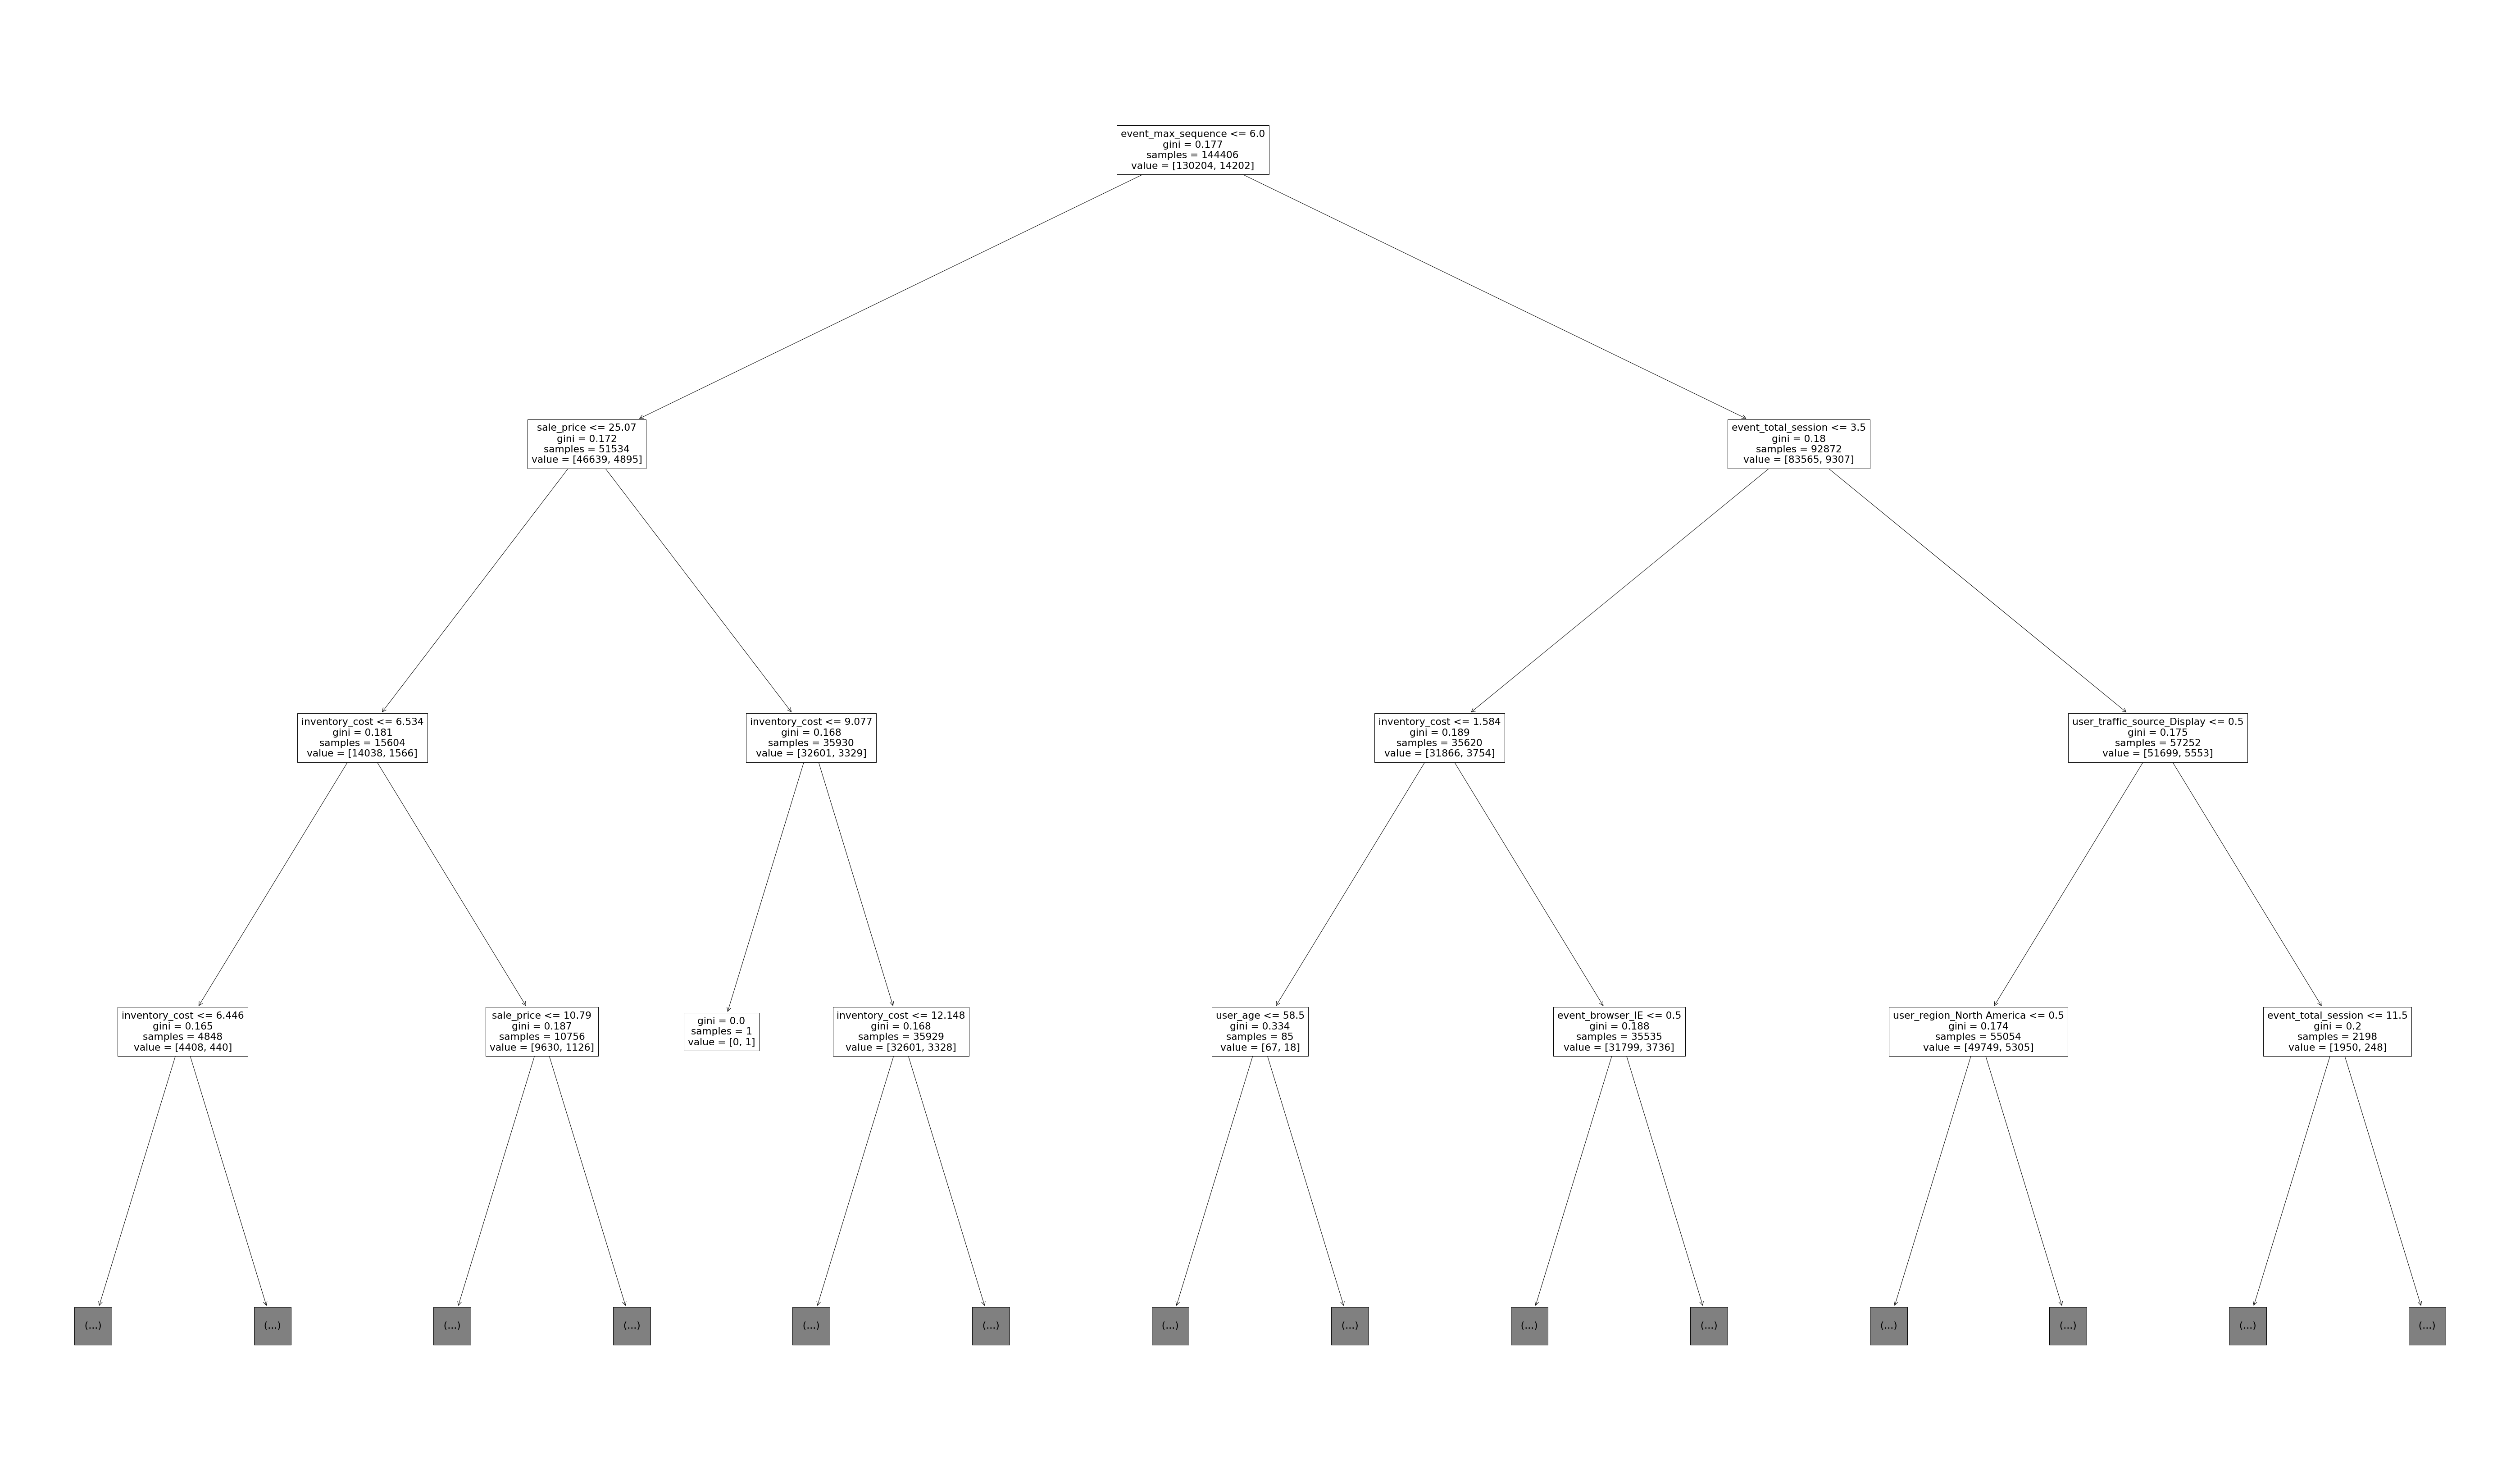

In [70]:
feature_names = (numerical_features + onehot.get_feature_names_out().tolist())

plt.figure(figsize=(100, 60))
plot_tree(model, max_depth=3, feature_names=feature_names)
plt.show()

In [71]:
# import graphviz

# dot_data = tree.export_graphviz(model, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("model") 

probability score

# **6. Evaluation**

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    130204
         1.0       1.00      1.00      1.00     14202

    accuracy                           1.00    144406
   macro avg       1.00      1.00      1.00    144406
weighted avg       1.00      1.00      1.00    144406



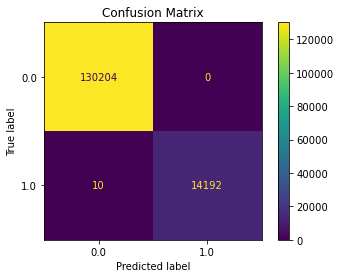

In [72]:
print(classification_report(y_train, preds_train))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     16276
         1.0       0.13      0.15      0.14      1775

    accuracy                           0.81     18051
   macro avg       0.52      0.52      0.52     18051
weighted avg       0.83      0.81      0.82     18051



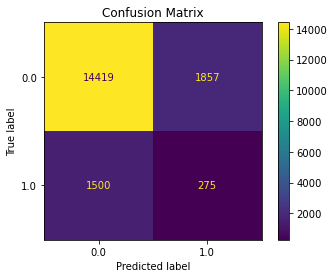

In [73]:
print(classification_report(y_dev, preds_dev))

ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     16276
         1.0       0.13      0.16      0.14      1775

    accuracy                           0.82     18051
   macro avg       0.52      0.52      0.52     18051
weighted avg       0.83      0.82      0.82     18051



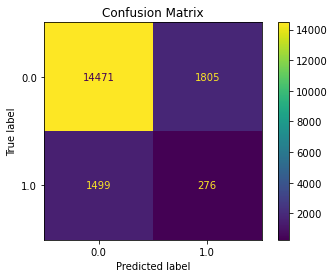

In [74]:
print(classification_report(y_test, preds_test))

ConfusionMatrixDisplay.from_predictions(y_test, preds_test)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

> ## INTERPRETASI

1. model memilki akurasi keseluruhan sebesar **82%**
2. model dapat memprediksi klasifikasi 0 (non-Returned) dengan **baik**, yaitu dengan f1-score sebesar **90%**
3. namun, model memprediksi klasifikasi 1 (Returned) dengan sangat **buruk**, yaitu dengan f1-score sebesar **14%**
4. Case yang diangkat berupa: *"Menganalisis pola dan ***penyebab product return*** oleh pelanggan berdasarkan data yang tersedia"*, sehingga **model ini tidak dapat digunakan**
5. Saran: menggunakan algoritma lain dan menambah data yang fit dengan case yang diangkat

In [75]:
print(export_text(model, feature_names=feature_names, max_depth=5, show_weights=True))

|--- event_max_sequence <= 6.00
|   |--- sale_price <= 25.07
|   |   |--- inventory_cost <= 6.53
|   |   |   |--- inventory_cost <= 6.45
|   |   |   |   |--- inventory_cost <= 6.45
|   |   |   |   |   |--- sale_price <= 13.51
|   |   |   |   |   |   |--- truncated branch of depth 37
|   |   |   |   |   |--- sale_price >  13.51
|   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |--- inventory_cost >  6.45
|   |   |   |   |   |--- weights: [0.00, 2.00] class: 1.0
|   |   |   |--- inventory_cost >  6.45
|   |   |   |   |--- sale_price <= 18.45
|   |   |   |   |   |--- warehouse_name_Los Angeles CA <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |--- warehouse_name_Los Angeles CA >  0.50
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- sale_price >  18.45
|   |   |   |   |   |--- event_total_session <= 2.00
|   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1.0
|   |   |   |   |   |--- event_tot

>dari hasil decision tree (dengan max_depth=5), ditemui hal menarik:

1. variabel event_max_sequence memiliki **kontribusi terbesar** dalam menentukan apakah suatu produk dilakukan return atau tidak
2. **kontribusi terbesar kedua** adalah variabel sale_price memiliki jika event_max_sequence <= 6.00 dan variabel event_total_session jika event_max_sequence >  6.00

## Exporting prediction

In [76]:
column_names = (
    numerical_features
    + onehot.get_feature_names_out().tolist()
)
df_x_processed = pd.concat(
    [
     # numerical features
     df_x[numerical_features].reset_index(drop=True),
     # one-hot encoded features
     pd.DataFrame(
         onehot.transform(df_x[categorical_features]).toarray(),
         columns=onehot.get_feature_names_out().tolist()
     ),
    ],
    axis=1
)
# df_x_processed_scaled = pd.DataFrame(
#     scaler.transform(df_x_processed),
#     columns=df_x_processed.columns
# )
#### dsiabled karena tidak melakukan scale di awal

print("Predicting all {} data..".format(df_x_processed.shape[0]))
preds_full = model.predict(df_x_processed)

print("Combine the prediction back to the original data..")
df_x_pred = df_x.assign(prediction=preds_full)

print("Overview of the resulting data..")
with pd.option_context("display.max_columns", None):
    display(df_x_pred.head())


Predicting all 180508 data..
Combine the prediction back to the original data..
Overview of the resulting data..


,id,sale_price,inventory_cost,inventory_product_department,warehouse_name,user_age,user_gender,user_traffic_source,event_total_session,event_max_sequence,event_browser,user_region,prediction
0,59347,2.5,1.1075,Women,Houston TX,12,F,Facebook,2,5,Chrome,East Asia,0.0
1,101072,2.5,1.1075,Women,Houston TX,17,F,Search,1,5,Chrome,Europe,0.0
2,63687,2.5,1.1075,Women,Houston TX,68,F,Search,6,10,Safari,Europe,0.0
3,16338,2.5,1.1075,Women,Houston TX,44,F,Email,1,5,Other,East Asia,0.0
4,85756,2.5,1.1075,Women,Houston TX,45,F,Organic,7,7,Safari,Europe,0.0


In [77]:
df_export = df_all.copy()
df_export.loc[(df_export['user_country'] == 'China')|(df_export['user_country'] == 'South Korea')|(df_export['user_country'] == 'Japan'), 'user_region'] = 'East Asia'
df_export.loc[(df_export['user_country'] == 'Brasil')|(df_export['user_country'] == 'Colombia'), 'user_region'] = 'South America'
df_export.loc[df_export['user_country'] == 'United States', 'user_region'] = 'North America'
df_export.loc[df_export['user_country'] == 'Australia', 'user_region'] = 'Australia'
df_export.loc[df_export['user_region'].isna(), 'user_region'] = 'Europe'
df_export

,id,status,sale_price,inventory_cost,inventory_product_category,inventory_product_name,inventory_product_brand,inventory_product_department,warehouse_name,warehouse_latitude,...,user_street_address,user_city,user_country,user_latitude,user_longitude,user_traffic_source,event_total_session,event_max_sequence,event_browser,user_region
0,59347,Shipped,2.50,1.10750,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,8796 Dominguez Overpass,Fuzhou,China,41.719322,123.485452,Facebook,2,5,Chrome,East Asia
1,101072,Shipped,2.50,1.10750,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,8646 Austin Radial Apt. 151,London,United Kingdom,51.460341,-0.137739,Search,1,5,Chrome,Europe
2,63687,Complete,2.50,1.10750,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,862 Christopher Radial Suite 221,Vannes,France,47.659633,-2.757229,Search,6,10,Safari,Europe
3,16338,Cancelled,2.50,1.10750,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,3016 Kelly Spurs,Hefei,China,41.232055,123.219074,Email,1,5,Other,East Asia
4,85756,Cancelled,2.50,1.10750,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,Houston TX,29.7604,...,16392 Robinson Harbors Apt. 238,Mataró,Spain,41.540629,2.448863,Organic,7,7,Safari,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,102243,Processing,9.32,4.49224,Dresses,Allegra K Lady Scoop Neck Short Sleeve Mini Dr...,Allegra K,Women,Charleston SC,32.7833,...,06348 Duffy Union,Shanghai,China,31.267552,121.457044,Search,4,13,Safari,East Asia
180504,134300,Processing,9.32,4.49224,Dresses,Allegra K Lady Scoop Neck Short Sleeve Mini Dr...,Allegra K,Women,Charleston SC,32.7833,...,44654 Marcus Port,Conceição do Coité,Brasil,-11.522655,-39.264287,Search,8,13,Safari,South America
180505,169592,Shipped,9.82,4.37972,Dresses,Allegra K Women Summer Elastic Waist Sleeveles...,Allegra K,Women,Charleston SC,32.7833,...,24739 Tonya Corners Suite 893,Jilin,China,31.170067,121.487507,Display,7,13,Firefox,East Asia
180506,84906,Complete,9.82,4.37972,Dresses,Allegra K Women Summer Elastic Waist Sleeveles...,Allegra K,Women,Charleston SC,32.7833,...,518 Clay Well Apt. 657,São Félix do Xingu,Brasil,-7.229394,-52.252309,Search,4,7,Safari,South America


In [78]:
df_prediction = pd.merge(df_export,df_orderitems[['id','created_at','shipped_at','delivered_at','returned_at']], on='id', how='left')
df_prediction = pd.merge(df_prediction,df_x_pred[['id','prediction']],on='id',how='left')

In [79]:
df_prediction.loc[df_prediction['prediction']==0, 'prediction'] = 'Non-Returned'
df_prediction.loc[df_prediction['prediction']==1, 'prediction'] = 'Returned'

In [80]:
df_prediction[df_prediction['prediction']=='Returned']

,id,status,sale_price,inventory_cost,inventory_product_category,inventory_product_name,inventory_product_brand,inventory_product_department,warehouse_name,warehouse_latitude,...,user_traffic_source,event_total_session,event_max_sequence,event_browser,user_region,created_at,shipped_at,delivered_at,returned_at,prediction
11,142678,Returned,3.00,1.26900,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,Men,Port Authority of New York/New Jersey NY/NJ,40.6340,...,Search,3,7,Chrome,East Asia,2021-11-02 02:32:52+00:00,2021-11-02 12:34:00+00:00,2021-11-06 20:31:00+00:00,2021-11-07 19:31:00+00:00,Returned
12,152447,Returned,3.00,1.26900,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,Men,Port Authority of New York/New Jersey NY/NJ,40.6340,...,Search,5,10,Safari,Australia,2021-10-12 07:11:30+00:00,2021-10-13 00:10:00+00:00,2021-10-14 01:20:00+00:00,2021-10-16 02:38:00+00:00,Returned
16,171473,Processing,3.00,1.26900,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,Men,Port Authority of New York/New Jersey NY/NJ,40.6340,...,Search,2,7,Firefox,East Asia,2022-02-15 12:13:03+00:00,NaT,NaT,NaT,Returned
19,39237,Returned,3.25,1.30325,Accessories,Black Silk Pre-Tied Bow Tie,UniformTux,Men,Port Authority of New York/New Jersey NY/NJ,40.6340,...,Organic,2,5,Safari,North America,2021-09-29 13:50:43+00:00,2021-10-01 05:37:00+00:00,2021-10-03 01:21:00+00:00,2021-10-05 00:24:00+00:00,Returned
32,65069,Complete,3.50,1.75000,Plus,Cotton Handkerchief with Large Monogram Embroi...,Greatlookz,Women,Houston TX,29.7604,...,Search,2,7,Firefox,Europe,2020-09-14 07:59:31+00:00,2020-09-15 22:19:00+00:00,2020-09-17 03:06:00+00:00,NaT,Returned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180485,36550,Returned,8.82,4.85100,Tops & Tees,Allegra K Ladies Boat Neck Long Sleeve Pullove...,Allegra K,Women,Charleston SC,32.7833,...,Organic,5,13,Safari,East Asia,2022-05-30 10:53:17+00:00,2022-05-29 17:43:00+00:00,2022-06-02 02:07:00+00:00,2022-06-02 22:20:00+00:00,Returned
180486,83752,Returned,8.82,5.08914,Tops & Tees,Allegra K Ladies See Through Mesh Long Sleeve ...,Allegra K,Women,Charleston SC,32.7833,...,Search,5,13,Firefox,North America,2021-07-30 00:58:57+00:00,2021-07-30 22:23:00+00:00,2021-08-01 01:52:00+00:00,2021-08-02 22:31:00+00:00,Returned
180487,84922,Returned,8.82,4.85100,Tops & Tees,Allegra K Ladies Boat Neck Long Sleeve Pullove...,Allegra K,Women,Charleston SC,32.7833,...,Search,9,13,Safari,East Asia,2022-03-23 14:45:29+00:00,2022-03-23 12:17:00+00:00,2022-03-27 19:50:00+00:00,2022-03-28 10:32:00+00:00,Returned
180488,98934,Returned,8.82,5.08914,Tops & Tees,Allegra K Ladies See Through Mesh Long Sleeve ...,Allegra K,Women,Charleston SC,32.7833,...,Search,5,10,Safari,South America,2020-12-29 10:55:02+00:00,2020-12-31 00:28:00+00:00,2021-01-02 15:30:00+00:00,2021-01-05 06:58:00+00:00,Returned


In [81]:
print("Export to CSV..")
df_prediction.to_csv("output_prediction_merged.csv", index=False)

print("Done!")

Export to CSV..
Done!
